# Autoencoders

For Colab, it downloads the data using the following code. 

If you work locally be sure to have the folder *data/*. You can download it from the repo.

In [177]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !rm -rf data
  !mv Capstone-Fall-2020-master/data/ data/
  !mv Capstone-Fall-2020-master/TS_utils.py /content/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

In [178]:
!pip -q install -U yellowbrick
!pip -q install scikit-learn-extra

In [179]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt

from TS_utils import TS_generator
from TS_utils import MedianScaler, DCT_lowpass_filter
from TS_utils import KMedians

# **Autoencoders**

In [180]:
import tensorflow as tf
import keras
from keras import Model, Input
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, InputLayer
import keras.regularizers as reg
from keras.optimizers import Adam

## Model

In [181]:
class Autoencoder:
    def __init__(self, time_step, n_features=1):
        self.encoder = Sequential()
        self.encoder.add(Dense(20, input_shape=(time_step,)))
                               #kernel_regularizer=reg.l1(0.001),
                               #bias_regularizer=reg.l1(0.001),
                               #activity_regularizer=reg.l1(0.001)) )
        #self.encoder.add(LSTM(10, input_shape=(time_step, n_features), return_sequences=True))
        #self.encoder.add(LSTM(20))

        self.decoder = Sequential()
        self.decoder.add(Dense(40, activation='relu'))
        self.decoder.add(Dense(time_step))

        self.autoencoder = Model( self.encoder.input, self.decoder(self.encoder.output) )
        self.encoding_model = Model( self.encoder.input, self.encoder.output )

        opt = Adam(learning_rate=0.0005)
        self.autoencoder.compile(optimizer=opt, loss='mse')
        print(self.autoencoder.summary())
        #print(self.encoding_model.summary())

    def fit(self, X_train, X_test, epochs=50, verbose=1):
        self.autoencoder.fit(X_train, X_train, batch_size=16, epochs=epochs, shuffle=True,
                             verbose=verbose, validation_data=(X_test, X_test))

    def encode(self, x):
        return self.encoding_model.predict(x)

    def predict(self, x):
        return self.autoencoder.predict(x)


## Preprocess and Train

In [182]:
#Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

n_ts = 1000

gen = TS_generator(nb_timeseries=2*n_ts, chunk_size=60)
X = gen.get_array()

lowpass_filter = DCT_lowpass_filter()
scaler = StandardScaler()
scaler = MinMaxScaler()
#scaler = MedianScaler()

Xdct = lowpass_filter.fit_transform(X)
Xscale = scaler.fit_transform(Xdct.T).T

X_train, X_val = Xscale[:n_ts,:], Xscale[n_ts:,:]
X_val_mm = (MinMaxScaler().fit_transform(Xdct.T).T)[n_ts:,:]
X_train.shape

(1000, 60)

In [183]:
model = Autoencoder(time_step=60)

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11_input (InputLayer)  [(None, 60)]              0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                1220      
_________________________________________________________________
sequential_11 (Sequential)   (None, 60)                3300      
Total params: 4,520
Trainable params: 4,520
Non-trainable params: 0
_________________________________________________________________
None


In [184]:
model.fit(X_train, X_val, epochs=100, verbose=1)

Epoch 1/100
63/63 [==============================] - 0s 4ms/step - loss: 0.2701 - val_loss: 0.1272
Epoch 2/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0579
Epoch 3/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0393
Epoch 4/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0288
Epoch 5/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0226
Epoch 6/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.0194
Epoch 7/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0175 - val_loss: 0.0167
Epoch 8/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0150 - val_loss: 0.0139
Epoch 9/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 10/100
63/63 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 11/

## Visualization of the training

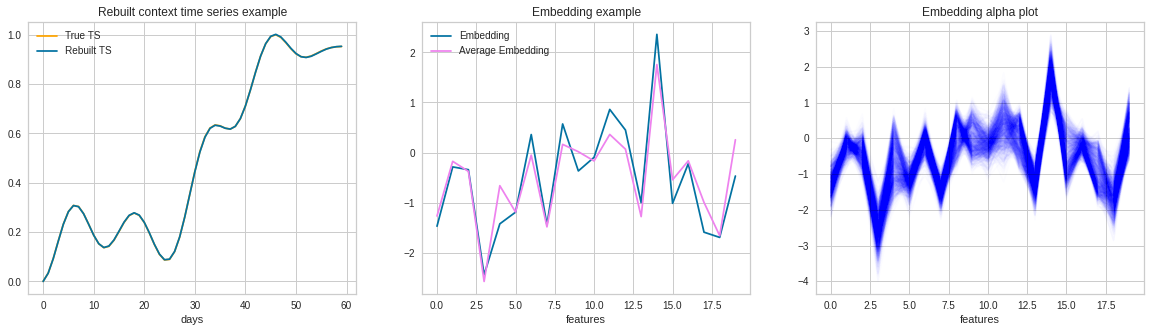

In [138]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

idx = 0
x_emb = model.encode(X_val[idx,:].reshape(1,60))[0]
x_rebuilt = model.predict(X_val[idx,:].reshape(1,60))[0]
mean_emb = model.encode(X_val).mean(axis=0)

ax[0].plot(X_val[idx,:], c='orange', label='True TS')
ax[0].plot(x_rebuilt, label='Rebuilt TS')
ax[0].set_xlabel('days')
ax[0].set_title('Rebuilt context time series example')
ax[0].legend()

ax[1].plot(x_emb, label='Embedding')
ax[1].plot(mean_emb, c='violet', label='Average Embedding')
ax[1].set_xlabel('features')
ax[1].set_title('Embedding example')
ax[1].legend()

x_emb = model.encode(X_val)
for i in range(len(X_val)):
    ax[2].plot(x_emb[i,:], alpha=0.01, c='blue')

ax[2].set_xlabel('features')
ax[2].set_title('Embedding alpha plot')

plt.show()

# Clustering

In [139]:
from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn_extra.cluster import KMedoids
from collections import Counter

In [168]:
mean = Xdct[n_ts:].mean(axis=1)
std =  Xdct[n_ts:].std(axis=1)
med = np.median(Xdct[n_ts:], axis=1)
mad = np.median(np.abs(Xdct[n_ts:].T - med).T, axis=1)

embedding = model.encode(X_val)
#embedding = (embedding.T * std) + mean
#embedding = (embedding.T * mad) + med
embedding = MinMaxScaler().fit_transform(embedding.T).T
embedding.shape

(1000, 20)

In [169]:
X_cluster = np.concatenate([X_val_mm[:,40:], embedding], axis=1)
#X_cluster = np.concatenate([X_val[:,40:], embedding], axis=1)
X_cluster.shape

(1000, 40)

In [175]:
cl = KMeans(n_clusters=10)
#cl = KMedians(n_clusters=10)
#cl = KMedoids(n_clusters=10, metric='euclidean')
y_train_pred = cl.fit_predict(X_cluster)

In [154]:
def visualizer(X_vis, labels, title, xlabel='days'):
  lines = (len(np.unique(y_train_pred)) - 1) // 5 + 1

  fig, ax = plt.subplots(lines, 5, figsize=(22, 5*lines))
  fig.suptitle(title)

  for j in range(5):
    for i in range(lines):
      indices = [k for k,label in enumerate(labels) if label == j + (5*i)]
      X_center = np.median(X_vis[indices,:], axis=0)
      for idx in indices:
        ax[i,j].plot(X_vis[idx,:], alpha=0.1, c='blue')
      ax[i,j].plot(X_center, c='orange', linewidth=4)
      ax[i,j].set_xlabel(xlabel)
      ax[i,j].set_title(f'Cluster {j + (5*i)} centroid (n={len(indices)})')

  plt.show()

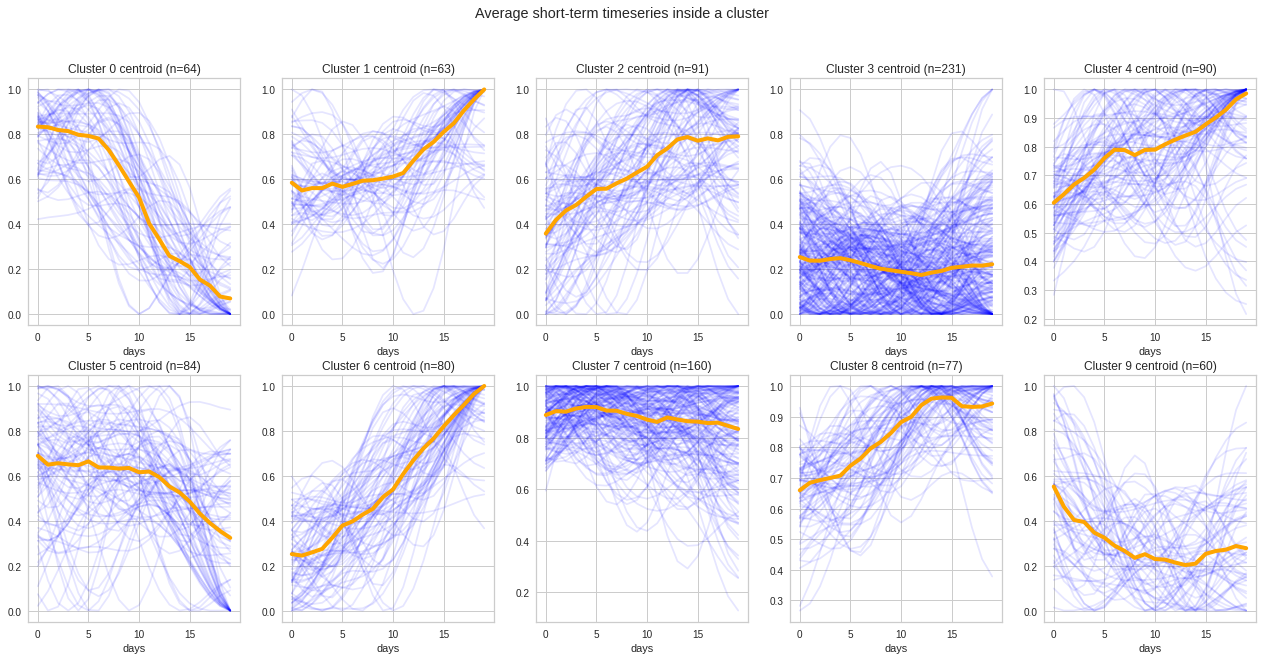

In [155]:
title = 'Average short-term timeseries inside a cluster'
visualizer(X_cluster[:,:20], y_train_pred, title=title)

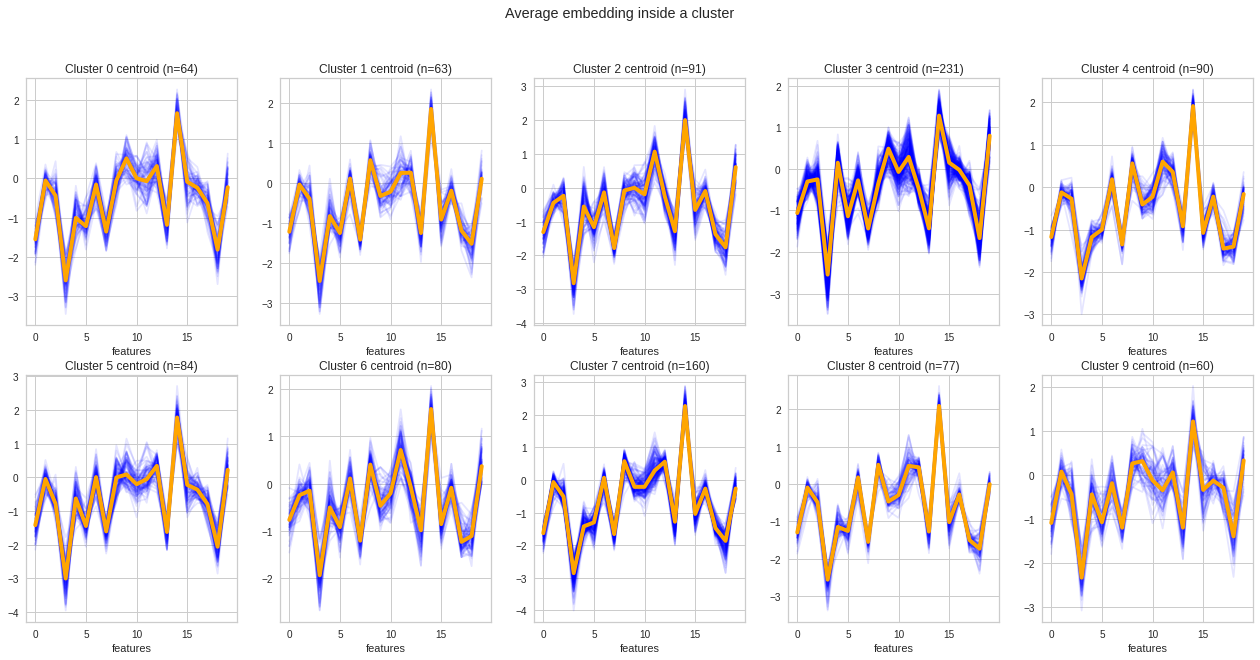

In [156]:
title = 'Average embedding inside a cluster'
visualizer(X_cluster[:,20:], y_train_pred, title=title, xlabel='features')

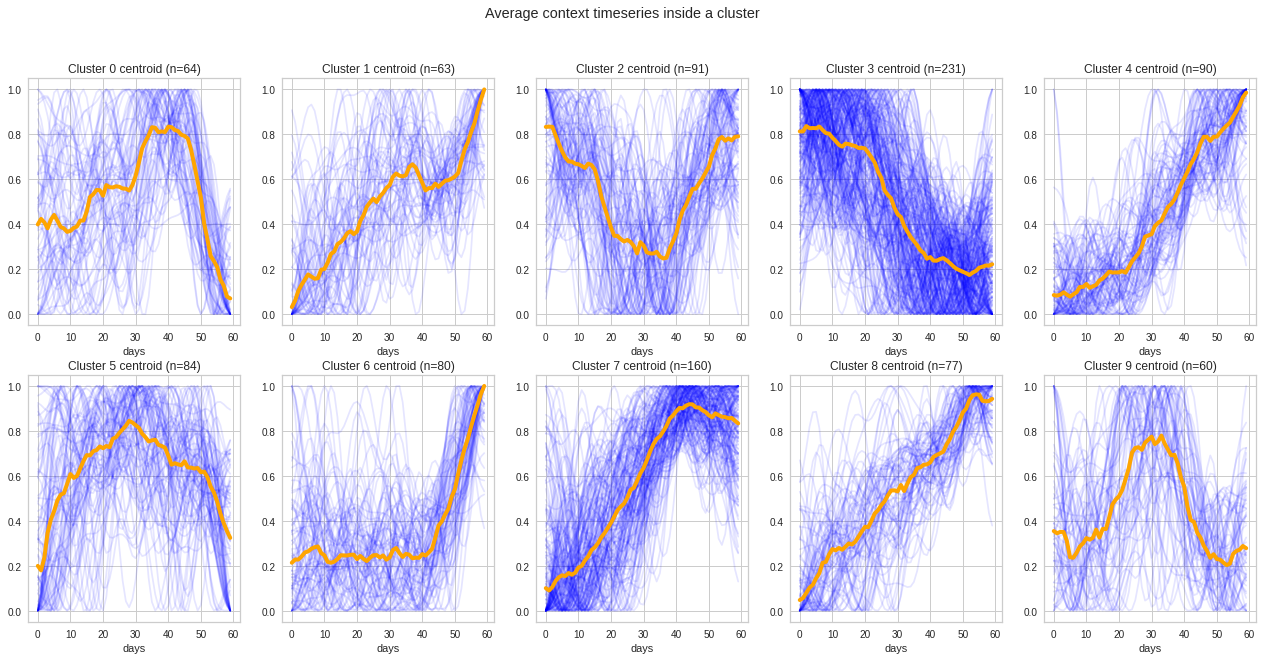

In [157]:
title = 'Average context timeseries inside a cluster'
visualizer(X_val_mm, y_train_pred, title=title)

## Silhouette score

In [158]:
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/lo

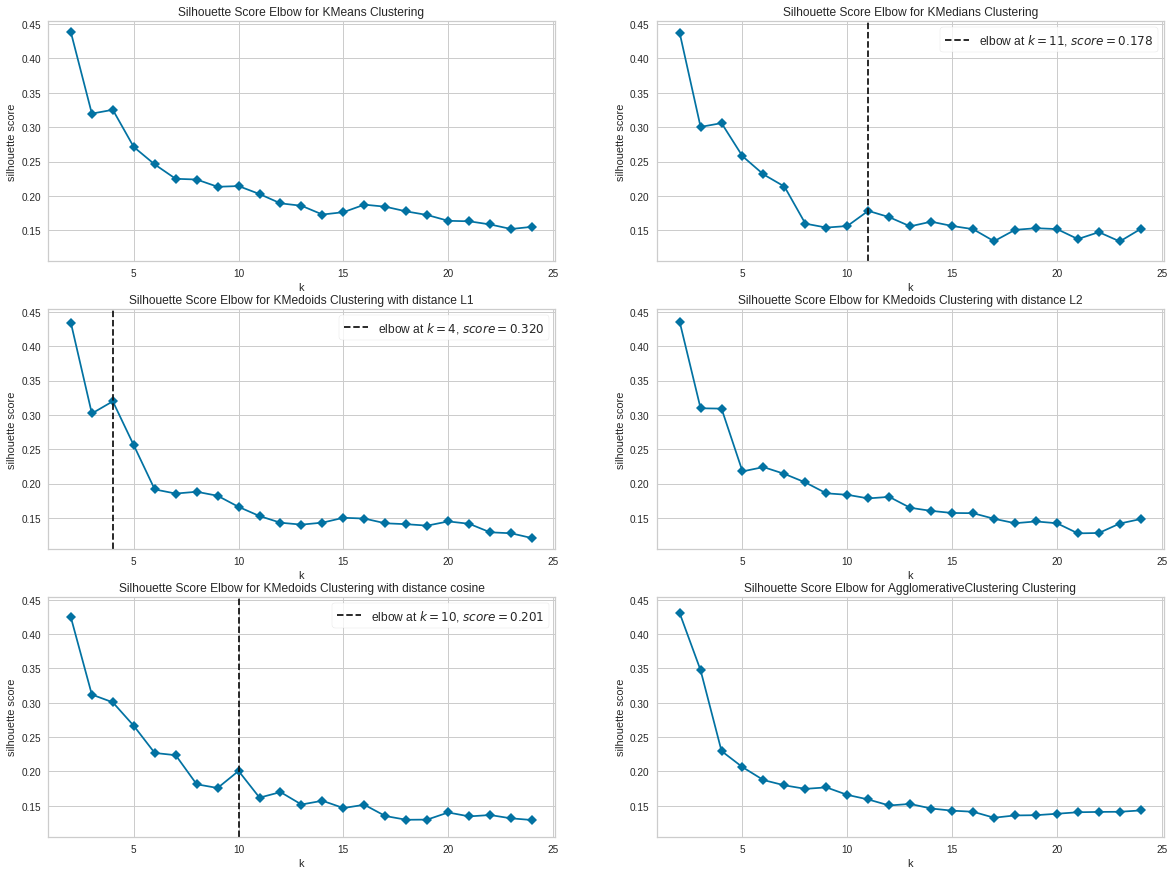

In [170]:
fig, ax = plt.subplots(3, 2, figsize=(20,15), sharey='all')
for a in fig.axes:
    a.tick_params(axis='y', which='both', left=True, labelleft=True)

title_medoid = 'Silhouette Score Elbow for KMedoids Clustering with distance '
metric='silhouette'

KElbowVisualizer(KMeans(), k=(2,25), metric=metric, ax=ax[0,0], timings=False).fit(X_cluster).finalize()
KElbowVisualizer(KMedians(), k=(2,25), metric=metric, ax=ax[0,1], timings=False).fit(X_cluster).finalize()
KElbowVisualizer(KMedoids(metric='l1'), k=(2,25), metric=metric, ax=ax[1,0], timings=False, title=title_medoid+'L1').fit(X_cluster).finalize()
KElbowVisualizer(KMedoids(metric='l2'), k=(2,25), metric=metric, ax=ax[1,1], timings=False, title=title_medoid+'L2').fit(X_cluster).finalize()
KElbowVisualizer(KMedoids(metric='cosine'), k=(2,25), metric=metric, ax=ax[2,0], timings=False, title=title_medoid+'cosine').fit(X_cluster).finalize()
KElbowVisualizer(AgglomerativeClustering(), k=(2,25), metric=metric, ax=ax[2,1], timings=False).fit(X_cluster).finalize()

plt.show()

In [176]:
from sklearn.metrics import silhouette_score

silhouette_score(X_cluster, y_train_pred)

0.21528999868671134

In [161]:
score = []
silhouette = []
max_cluster=25

for k in range(2,max_cluster):
  cl = KMedians(n_clusters=k)
  y_train_pred = cl.fit_predict(X_cluster)
  silhouette.append( silhouette_score(X_cluster, y_train_pred) )
  score.append(cl.inertia_)

Text(0.5, 1.0, 'Silhouette score')

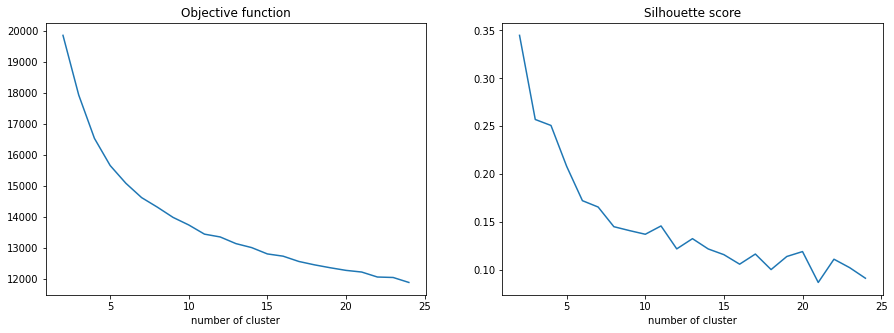

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(list(range(2,max_cluster)), score)
ax[0].set_xlabel('number of cluster')
ax[0].set_title(f'Objective function')

ax[1].plot(list(range(2,max_cluster)), silhouette)
ax[1].set_xlabel('number of cluster')
ax[1].set_title(f'Silhouette score')

In [ ]:
def elbow(score_tab):
  a = (score_tab[-1] - score_tab[0]) / len(score_tab)
  b = score_tab[0]

  elb_tab = [ np.abs(score_tab[i] - a*i - b) / np.sqrt(a*a + 1) for i in range(len(score_tab)) ]
  return elb_tab.index(max(elb_tab))

In [ ]:
print("Best k for KMeans with objective function:", elbow(score)+2)
print("Best k for KMeans with silhouette score:", elbow(silhouette)+2)

Best k for KMeans with objective function: 7
Best k for KMeans with silhouette score: 8


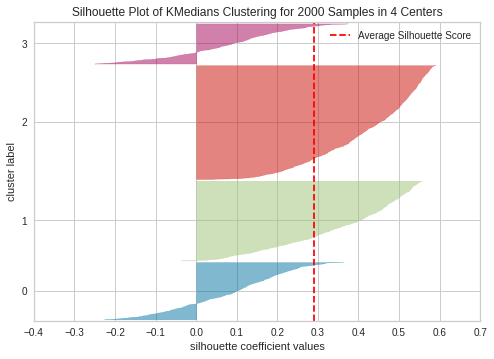

In [ ]:
visualizer = SilhouetteVisualizer(KMedians(n_clusters=elbow(silhouette)+2), colors='yellowbrick')
visualizer.fit(X_cluster) 
visualizer.show();

In [ ]:
cl = KMedians(n_clusters=elbow(silhouette)+2)
y_train_pred = cl.fit_predict(X_cluster)
silhouette_score(X_cluster, y_train_pred)

0.28826039352741

In [ ]:
from sklearn.metrics import silhouette_samples

def sil_sample_cluster(data, col1, col2, thresh):
  '''
  computes the percentage of silhouette scores about a threshold within each cluster
  (input) data: DataFrame; col1: str refering to cluster column; col2: str refering to silhouette scores column; thresh: float between -1 and 1
  (output) ss_scores; dictionary
  '''
  ss_scores = {}
  for i in range(data[col1].nunique()):
    subs = data[data[col1]==i]
    ss_thresh = subs[subs[col2]>=thresh]
    ss_scores[i] = len(ss_thresh)/len(subs)
  
  return ss_scores

In [ ]:
from sklearn.metrics import silhouette_samples

silhouette_scores = silhouette_samples(X_cluster, y_train_pred)

clusters_ss = pd.concat([pd.DataFrame(y_train_pred, columns= ['cluster']), pd.DataFrame(silhouette_scores, columns = ['silhouette_score'])], axis = 1)
clusters_ss.head() 

sil_sample_cluster(clusters_ss, 'cluster', 'silhouette_score', 0.3) #0 for all

{0: 0.6672932330827067,
 1: 0.7924050632911392,
 2: 0.04961832061068702,
 3: 0.03365384615384615}

## Other visualizations

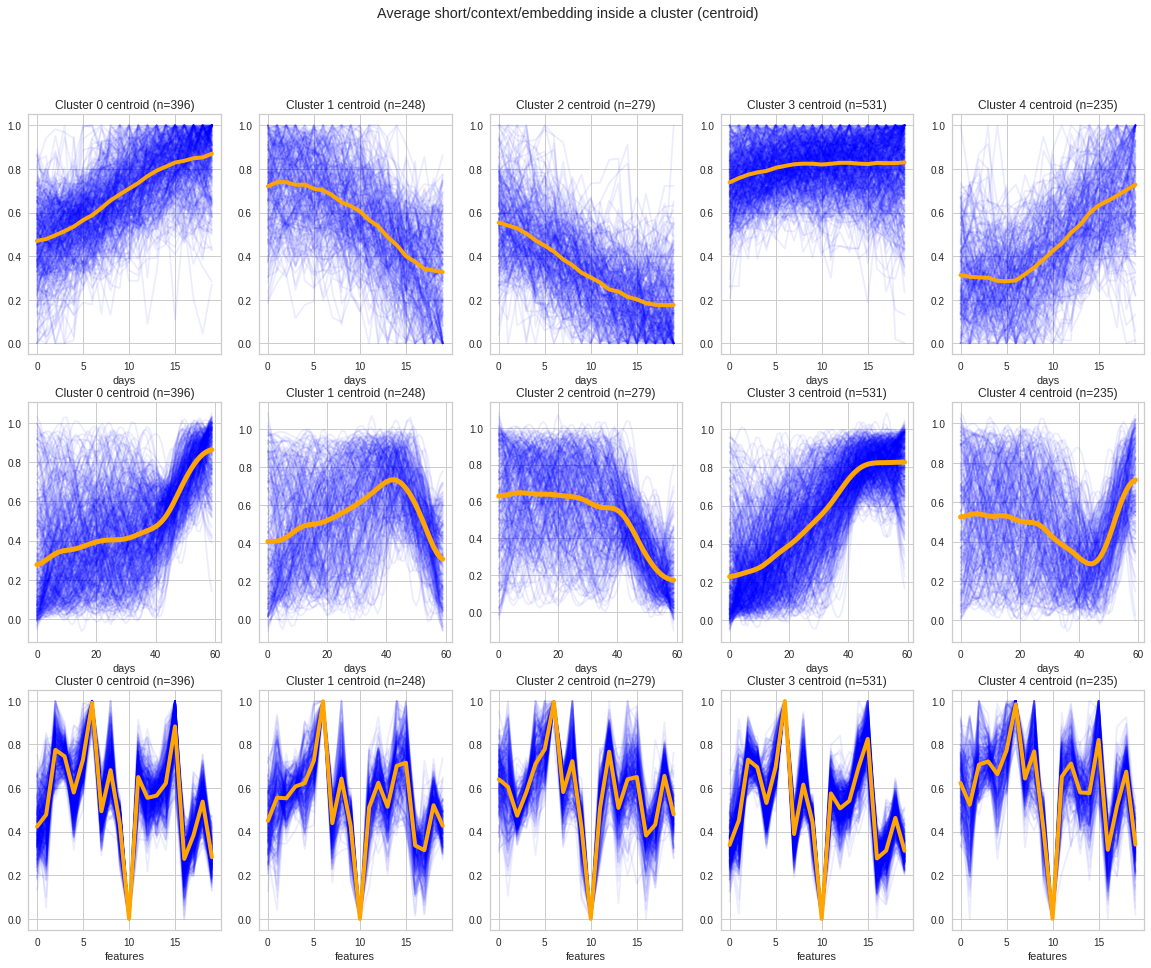

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(20,15))
fig.suptitle('Average short/context/embedding inside a cluster (centroid)')

for k in range(5):

  indices = [i for i,x in enumerate(y_train_pred) if x == k]
  X_mean = X_cluster[indices,:20].mean(axis=0)
  for idx in indices:
    ax[0,k].plot(X_cluster[idx,:20], alpha=0.075, c='blue')
  ax[0,k].plot(X_mean, c='orange', linewidth=4)
  ax[0,k].set_xlabel('days')
  ax[0,k].set_title(f'Cluster {k} centroid (n={len(indices)})')


  X_mean = X_train[indices,:].mean(axis=0)
  for idx in indices:
    ax[1,k].plot(X_train[idx,:], alpha=0.075, c='blue')
  ax[1,k].plot(X_mean, c='orange', linewidth=5)
  ax[1,k].set_xlabel('days')
  ax[1,k].set_title(f'Cluster {k} centroid (n={len(indices)})')


  X_mean = X_cluster[indices,20:].mean(axis=0)
  for idx in indices:
    ax[2,k].plot(X_cluster[idx,20:], alpha=0.075, c='blue')
  ax[2,k].plot(X_mean, c='orange', linewidth=4)
  ax[2,k].set_xlabel('features')
  ax[2,k].set_title(f'Cluster {k} centroid (n={len(indices)})')




plt.show()

In [ ]:
class T_Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super(T_Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        ind = np.triu_indices(n=input_shape[-1], m=self.units, k=1)
        self.w[tf.constant(ind[0])].trainable = False

        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b